# Custom Training with Tensorflow 2.0 

## Ce que vous apprendrez durant ce cours 

Utiliser du transfer learning ou se baser sur des architectures existantes sera suffisant pour la majorité des projets de Deep Learning. 

Cependant, il est parfois nécessaire de créer des modèles spécifiques. Ceci arrive notamment lorsqu'on utilise des algorithmes GAN (Generative Adversarial Networks). 

Pour atteindre ce niveau, nous allons d'abord apprendre à créer un entrainement custom, puis nous verrons comment nous pouvons créer des modèles ainsi que des fonctions de coût custom, on entend par custom "customisé" c'est-à-dire sur mesure.

In [ ]:
#!pip install tensorflow-gpu==2.0.0beta1
import tensorflow as tf 
import numpy as np 

## Création d'un modèle de régression linéaire custom

Pour illustrer l'apprentissage "custom" nous allons considérer un modèle simple de régression linéaire `y = 3x + 2`

1. Nous allons définir un jeu de données (x, y) qui suit l'équation ci-dessus mais avec une part d'aléatoire (un bruit) pour avoir des données un peu plus proches de ce qui pourrait se passer dans la réalité
2. Nous allons définir un modèle linéaire de la forme y = ax + b avec les fonctions de tensorflow 
3. Nous allons faire converger le modele en utilisant les classiques fonction de coût _MSE_ et la descente de gradient

In [ ]:
# Définition du modèle 

class Model(object):
  def __init__(self):
    
    self.W = tf.Variable(float(np.random.randn(1)))
    self.b = tf.Variable(float(np.random.randn(1)))

  def __call__(self, x):
    return self.W * x + self.b

model = Model()

model(1) == model.__call__(1)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.13309686>

Ici, nous définissions une classe très simple qui sera notre modèle. Elle s'initialise avec deux variables aléatoires : 

* W --> _weight_ ou le coefficient 
* b --> _constant_ ou la constante 


Nous définissions ensuite une fonction *__call__* qui va retourner l'équation d'une régression linéaire simple. Nous pourrons ensuite créer une instance du modèle et faire une première prédiction pour `x = 3`

In [ ]:
model(3.0).numpy()

-4.7398567

Si nous voulions atteindre `3x+2` nous aurions dû obtenir `11`. Nous sommes donc assez loin du résultat ! 

## Création d'une fonction de coût 

Nous allons maintenant créer une fonction de coût qui nous permettra de définir à quel point nous sommes loin de la valeur que le modèle devait prédire. 

Puisque nous sommes dans une problématique de régression, nous allons définir une fonction `MSE`

In [ ]:
# Définition d'une loss MSE 
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

x = tf.constant([0,1,2])
y = tf.constant([1,2,3])

loss(x,y).numpy()

1

## Création de données

Nous avons défini notre fonction, nous pouvons créer des données qui vont suivre :

`y = 3x +2`

Pour ajouter un peu de difficulté, nous allons ajouter un peu de bruit pour éviter d'avoir une ligne droite trop parfaite. 

In [ ]:
# Create random data 
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

In [ ]:
model.W
model.b

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.13309686>

In [ ]:
inputs[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.1291769 , -1.0885981 , -2.3220446 ,  0.07699117, -1.9222251 ],
      dtype=float32)>

In [ ]:
noise[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.10265321,  1.3699169 ,  0.03628524,  0.7338921 , -1.8677986 ],
      dtype=float32)>

In [ ]:
outputs[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.509816  ,  0.10412264, -4.9298487 ,  2.9648657 , -5.634474  ],
      dtype=float32)>

## Visualisation des données 

Regardons maintenant les données que nous avons créees ainsi que la première prédiction aléatoire rendue par notre modèle sur toutes nos données d'entraînement (les 1000 points)

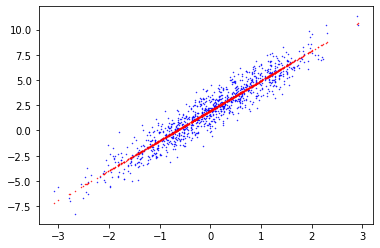

Valeur de la MSE: 
0.996911
Ecart moyen entre une prédiction et un vrai label: 
0.9984543


In [ ]:
## Plot the model 

import matplotlib.pyplot as plt

# Le graphe bleu représente les données générées
plt.scatter(inputs, outputs, c='b', s=.2)

# Le graphe bleu représente les prédictions du modele
plt.scatter(inputs, model(inputs), c='r', s=.2)
plt.show()

# on regarde la valeur de notre loss
print('Valeur de la MSE: '),
print(loss(model(inputs), outputs).numpy())

# Pour avoir une idée de l'écart moyen entre nos prédictions
# et nos labels on doit prendre la racine de la loss
print('Ecart moyen entre une prédiction et un vrai label: '),
print(np.sqrt(loss(model(inputs), outputs).numpy()))

## Création d'une boucle d'entrainement 

Maintenant que nous avons un modèle et une fonction de coût, il ne nous reste qu'à assembler le tout dans une boucle d'entraînement. Pour cela, il faudra : 

* Compiler le gradient de notre loss 
* Soustraire le gradient multiplié par le learning rate pour approcher un minimum de notre fonction 
* On répétera l'opération sur le nombre d'epochs que nous définirons plus tard

Créons d'abord une fonction qui s'occupera de gérer la mise à jour des gradients 

In [ ]:
## Fonction d'entrainement 
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:                           # Cette ligne nous permet d'enregistrer les gradients de notre loss
    current_loss = loss(model(inputs), outputs)          # On calcule notre loss
  dW, db = t.gradient(current_loss, [model.W, model.b])  # On calcule les gradients pour W et pour b
  model.W.assign_sub(learning_rate * dW)                 # On soustrait le gradient * lr pour approcher le minimum
  model.b.assign_sub(learning_rate * db)

Commencons notre phase d'entraînement, nous allons définir 10 epochs pour approcher le minimum de notre fonction de coût. On enregistrera chacune des phases de l'entraînement pour pouvoir les mettre dans un graphique. 

Epoch 0, W = 0.4059785008430481, b = 1.3974997997283936, loss = 7.608723163604736 
Epoch 1, W = 2.863762140274048, b = 1.9438350200653076, loss = 1.008156418800354 
Epoch 2, W = 2.9646787643432617, b = 1.9682762622833252, loss = 0.9969301819801331 
Epoch 3, W = 2.9688422679901123, b = 1.9692797660827637, loss = 0.9969111084938049 
Epoch 4, W = 2.9690141677856445, b = 1.9693211317062378, loss = 0.9969109892845154 
Epoch 5, W = 2.9690213203430176, b = 1.969322919845581, loss = 0.9969110488891602 
Epoch 6, W = 2.9690215587615967, b = 1.969322919845581, loss = 0.9969109892845154 
Epoch 7, W = 2.9690215587615967, b = 1.969322919845581, loss = 0.9969109892845154 
Epoch 8, W = 2.9690215587615967, b = 1.969322919845581, loss = 0.9969109892845154 
Epoch 9, W = 2.9690215587615967, b = 1.969322919845581, loss = 0.9969109892845154 


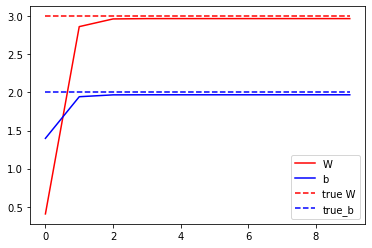

In [ ]:
## Training 

model = Model()

# On va stocker l'historique des valeurs de W et b, on crée 2 listes pour cela
Ws, bs = [], []
epochs = range(10)

# On itere sur le nombre d'epoch, 10 epoch signifie que le modele va parcourir les
# 1000 valeurs du set d'entraînement 10 fois
for epoch in epochs:
  
  # On stocke les valeurs du poids et du biais pour l'epoch courant
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  
  # On calcule la loss de l'epoch courant pour pouvoir l'afficher
  current_loss = loss(model(inputs), outputs)
  
  # On fait la descente de gradient (on update W et b)
  train(model, inputs, outputs, 0.5)

  # On affiche la valeur des poids et la loss
  print("Epoch {}, W = {}, b = {}, loss = {} ".format(epoch, Ws[-1], bs[-1], current_loss))
  
plt.plot(epochs, Ws, 'r', 
         epochs, bs, 'b')

plt.plot([TRUE_W] * len(epochs), "r--",
         [TRUE_b] * len(epochs), 'b--')

plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()

Comme on peut le voir, nous arrivons très rapidement à un modèle qui prédit extrêmement bien ! 

## Ressources 

[Custom Training basics](https://www.tensorflow.org/beta/tutorials/eager/custom_training)